
<div style="text-align:center; font-size:32px;">
XGB_boost Model
</div>

---

### Import necessary librairies

In [213]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,root_mean_squared_error
from xgboost import XGBRegressor

## Data prep
---

In [214]:
# Charger le fichier Excel
df_excel_complete = pd.read_excel('Proj_B1_consolidado_indicadores_Eloi_version.xlsx')

# Sauvegarder le DataFrame en CSV
df_excel_complete.to_csv('Proj_B1_consolidado_indicadores.csv', index=False)

# Vérifier la conversion
df_excel_complete.head()


,DATE,Bananas,Bananas s/prod22,Proj_Bananas,Proj_Bananas 2,Proj_Bananas_Eloi,Bananas actuel,GDP,Inflation,Unemployment_Rate,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,201907.0,NaN,NaN,NaN,NaN,NaN,NaN,0.4,-0.7,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201908.0,NaN,NaN,NaN,NaN,NaN,NaN,0.4,-0.1,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201909.0,NaN,NaN,NaN,NaN,NaN,NaN,0.4,-0.3,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201910.0,NaN,NaN,NaN,NaN,NaN,NaN,0.8,-0.1,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201911.0,NaN,NaN,NaN,NaN,NaN,NaN,0.8,0.2,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [215]:
df_excel_complete.columns

Index(['DATE', 'Bananas', 'Bananas s/prod22', 'Proj_Bananas', 'Proj_Bananas 2',
       'Proj_Bananas_Eloi', 'Bananas actuel', 'GDP', 'Inflation',
       'Unemployment_Rate', 'LT_Interest_Rate', 'ST_Interest_RateE3m',
       'Euribor1year', 'Unnamed: 13', 'Unnamed: 14', 'Idmes', 'Quarter',
       'GDP.1', 'Inflation.1', 'Unemployment_Rate.1', 'LT_Interest_Rate.1',
       'ST_Interest_Rate', 'Euribor1year.1', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32',
       'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36'],
      dtype='object')

In [216]:
# Sélections of necessary columns
columns_needed = ['DATE',
                  'Bananas',
                  'GDP',
                  'Inflation',
                  'Unemployment_Rate',
                  'LT_Interest_Rate',
                  'ST_Interest_RateE3m',
                  'Euribor1year']

df_reduced=df_excel_complete[columns_needed]
df_reduced.head()


,DATE,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_RateE3m,Euribor1year
0,201907.0,NaN,0.4,-0.7,6.6,0.44,-0.3649,-0.2833
1,201908.0,NaN,0.4,-0.1,6.5,0.17,-0.4077,-0.3563
2,201909.0,NaN,0.4,-0.3,6.6,0.20,-0.4176,-0.3391
3,201910.0,NaN,0.8,-0.1,6.6,0.19,-0.4129,-0.3042
4,201911.0,NaN,0.8,0.2,6.8,0.35,-0.4013,-0.2720


In [217]:
# Recharger la colonne DATE en string -> enlève le .0 a la fin du numéro de l'année 
df_excel_complete['DATE'] = df_excel_complete['DATE'].astype(str).str.replace('.0', '', regex=False)
df_excel_complete

,DATE,Bananas,Bananas s/prod22,Proj_Bananas,Proj_Bananas 2,Proj_Bananas_Eloi,Bananas actuel,GDP,Inflation,Unemployment_Rate,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
0,201907,NaN,NaN,NaN,NaN,NaN,NaN,0.40,-0.7,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201908,NaN,NaN,NaN,NaN,NaN,NaN,0.40,-0.1,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201909,NaN,NaN,NaN,NaN,NaN,NaN,0.40,-0.3,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201910,NaN,NaN,NaN,NaN,NaN,NaN,0.80,-0.1,6.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201911,NaN,NaN,NaN,NaN,NaN,NaN,0.80,0.2,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,202609,NaN,NaN,0.041669,0.046641,0.056287,0.075658,1.95,2.6,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,202610,NaN,NaN,0.041428,0.046066,0.055502,0.075658,1.97,2.6,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,202611,NaN,NaN,0.041253,0.045077,0.054870,0.075658,1.97,2.6,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,202612,NaN,NaN,0.036705,0.044155,0.054381,0.075658,1.97,2.6,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
# Extraire l'année et le mois (supposons que le format est 'YYYYMM')
df_excel_complete['DATE'] = pd.to_datetime(df_excel_complete['DATE'], format='%Y%m')

# Sélectionner les colonnes nécessaires
columns_needed = ['DATE', 'Bananas', 'GDP', 'Inflation', 'Unemployment_Rate', 'LT_Interest_Rate', 'ST_Interest_RateE3m', 'Euribor1year']
df_reduced = df_excel_complete[columns_needed]

# Mettre la colonne DATE en index
df_reduced = df_reduced.set_index('DATE')

In [219]:
#on met la date en index du datasest
df_reduced.index = pd.to_datetime(df_reduced.index)
df_reduced.head()

,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_RateE3m,Euribor1year
DATE,,,,,,,
2019-07-01,NaN,0.4,-0.7,6.6,0.44,-0.3649,-0.2833
2019-08-01,NaN,0.4,-0.1,6.5,0.17,-0.4077,-0.3563
2019-09-01,NaN,0.4,-0.3,6.6,0.20,-0.4176,-0.3391
2019-10-01,NaN,0.8,-0.1,6.6,0.19,-0.4129,-0.3042
2019-11-01,NaN,0.8,0.2,6.8,0.35,-0.4013,-0.2720


In [220]:
# on supprime la dernière ligne qui est incomplète
df_reduced=df_reduced.iloc[:-1,:]
print(df_reduced.dtypes)

Bananas                float64
GDP                    float64
Inflation               object
Unemployment_Rate      float64
LT_Interest_Rate       float64
ST_Interest_RateE3m     object
Euribor1year           float64
dtype: object


In [221]:
cols_to_convert = ['Inflation', 'ST_Interest_RateE3m']

for col in cols_to_convert:
    df_reduced[col] = pd.to_numeric(df_reduced[col], errors='coerce')

In [222]:
# Filtrer les données connues (jusqu'à juillet 2025 inclus)
df_known = df_reduced.loc[:'2025-07']

# Convertir les colonnes nécessaires en float
cols_to_convert = ['Inflation', 'ST_Interest_RateE3m']

for col in cols_to_convert:
    df_known[col] = pd.to_numeric(df_known[col], errors='coerce')

# Vérifier que tout est bien float maintenant
print(df_known.dtypes)

# Séparation train/test sur les données connues
train_size = int(len(df_known) * 0.8)
train, test = df_known[:train_size], df_known[train_size:]
train = train.dropna()
# Données à prédire (après juillet 2025)
df_forecast = df_reduced.loc['2025-08':]

# Vérification
print(train.shape, test.shape)
print(df_forecast.shape)

Bananas                float64
GDP                    float64
Inflation              float64
Unemployment_Rate      float64
LT_Interest_Rate       float64
ST_Interest_RateE3m    float64
Euribor1year           float64
dtype: object
(46, 7) (15, 7)
(17, 7)


/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_1773/1863211086.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_known[col] = pd.to_numeric(df_known[col], errors='coerce')



---


### Feature prep

In [223]:
#definir X et y pour l'entrainement du modele
features = ['GDP', 'Inflation', 'Unemployment_Rate', 'LT_Interest_Rate', 'ST_Interest_RateE3m', 'Euribor1year']
X_train = train[features]
y_train = train['Bananas']
X_test = test[features]
y_test = test['Bananas']


In [224]:
X_train

,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_RateE3m,Euribor1year
DATE,,,,,,
2020-07-01,14.4,-0.1,8.2,0.40,-0.4441,-0.2789
2020-08-01,14.4,-0.2,8.3,0.36,-0.4797,-0.3589
2020-09-01,14.4,-0.8,8.1,0.32,-0.4914,-0.4146
2020-10-01,0.2,-0.6,7.6,0.18,-0.5091,-0.4660
2020-11-01,0.2,-0.4,7.2,0.07,-0.5209,-0.4806
2020-12-01,0.2,-0.3,6.9,0.03,-0.5381,-0.4966
2021-01-01,-2.8,0.2,7.0,0.03,-0.5472,-0.5047
2021-02-01,-2.8,0.3,7.0,0.16,-0.5411,-0.5009
2021-03-01,-2.8,0.1,6.8,0.23,-0.5391,-0.4867


In [225]:
y_train

DATE
2020-07-01    0.043437
2020-08-01    0.040134
2020-09-01    0.040497
2020-10-01    0.041286
2020-11-01    0.042188
2020-12-01    0.042471
2021-01-01    0.041921
2021-02-01    0.039109
2021-03-01    0.036047
2021-04-01    0.027355
2021-05-01    0.023560
2021-06-01    0.023568
2021-07-01    0.025691
2021-08-01    0.025819
2021-09-01    0.026737
2021-10-01    0.027689
2021-11-01    0.028446
2021-12-01    0.029269
2022-01-01    0.027318
2022-02-01    0.027579
2022-03-01    0.028315
2022-04-01    0.032446
2022-05-01    0.033680
2022-06-01    0.035237
2022-07-01    0.036317
2022-08-01    0.041387
2022-09-01    0.042503
2022-10-01    0.045632
2022-11-01    0.051418
2022-12-01    0.056538
2023-01-01    0.059207
2023-02-01    0.064510
2023-03-01    0.071183
2023-04-01    0.076833
2023-05-01    0.080064
2023-06-01    0.083302
2023-07-01    0.086610
2023-08-01    0.088941
2023-09-01    0.085664
2023-10-01    0.087588
2023-11-01    0.086182
2023-12-01    0.082701
2024-01-01    0.078117
2024-0

In [226]:
print(X_train.dtypes)

GDP                    float64
Inflation              float64
Unemployment_Rate      float64
LT_Interest_Rate       float64
ST_Interest_RateE3m    float64
Euribor1year           float64
dtype: object


## Final version of XGB_boost with K-fold, lags and itératives predictions

---

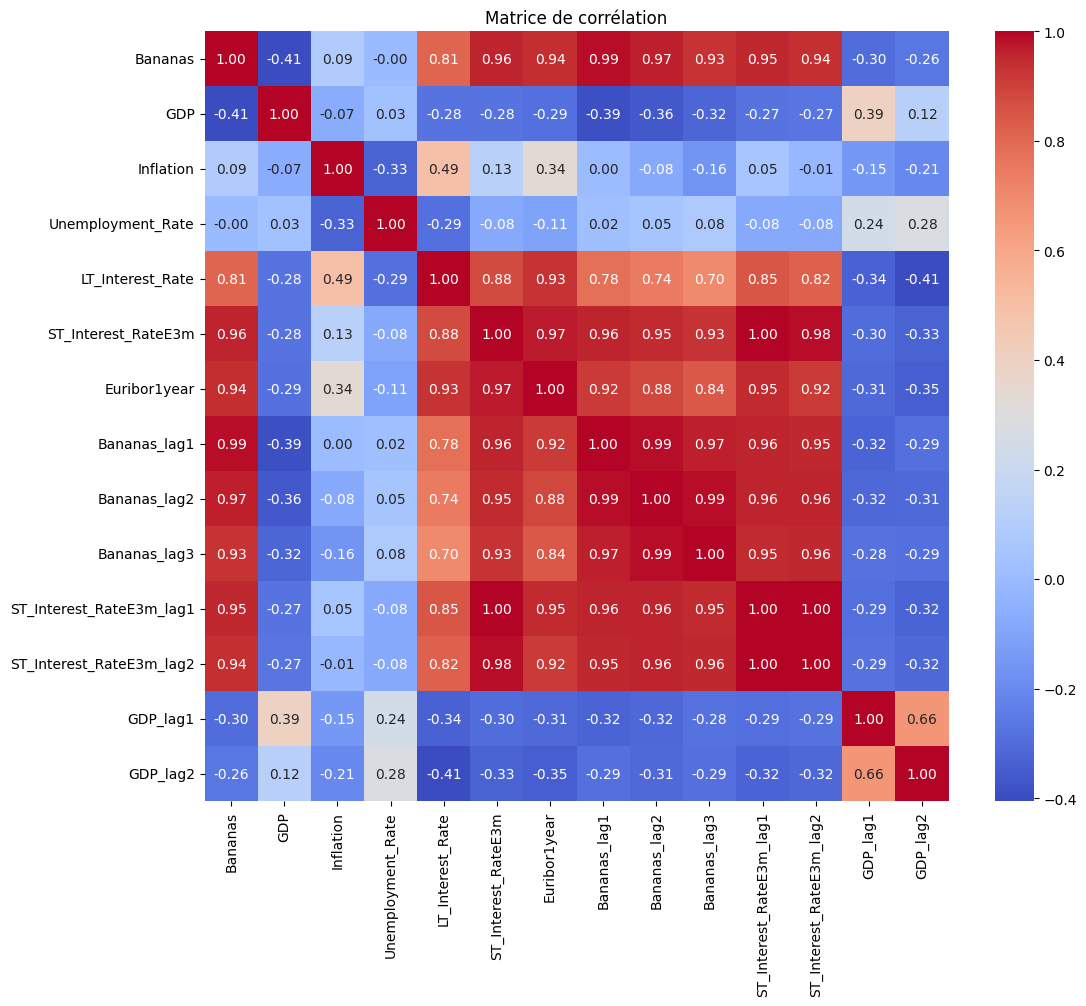

Fold 1 RMSE: 0.00330
Fold 2 RMSE: 0.00429
Fold 3 RMSE: 0.00489
Fold 4 RMSE: 0.00325
Fold 5 RMSE: 0.00256


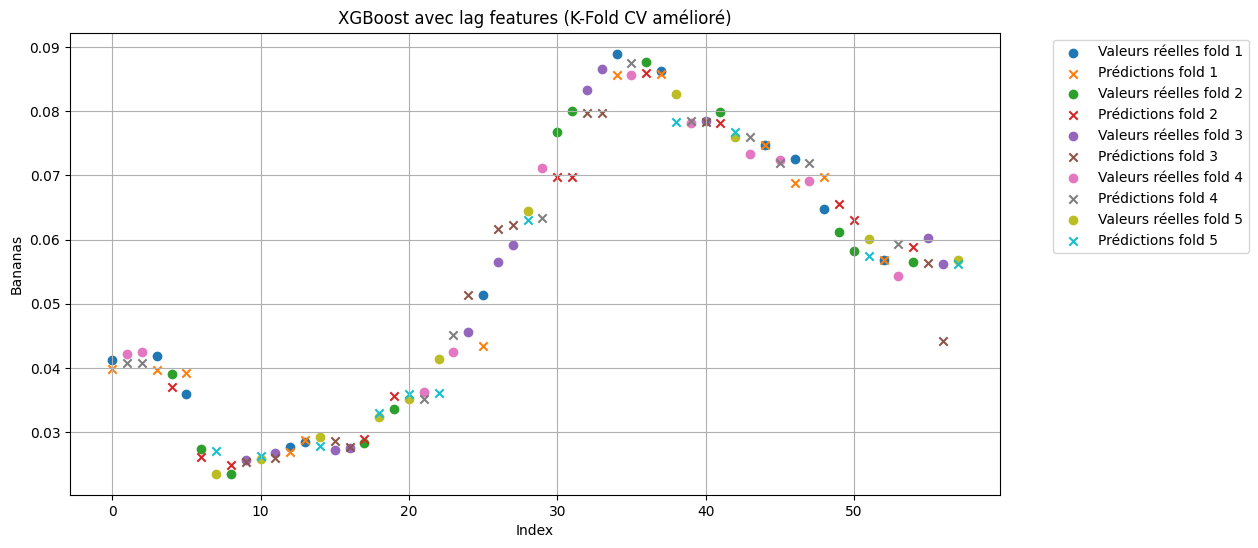

RMSE moyen sur tous les folds: 0.00366


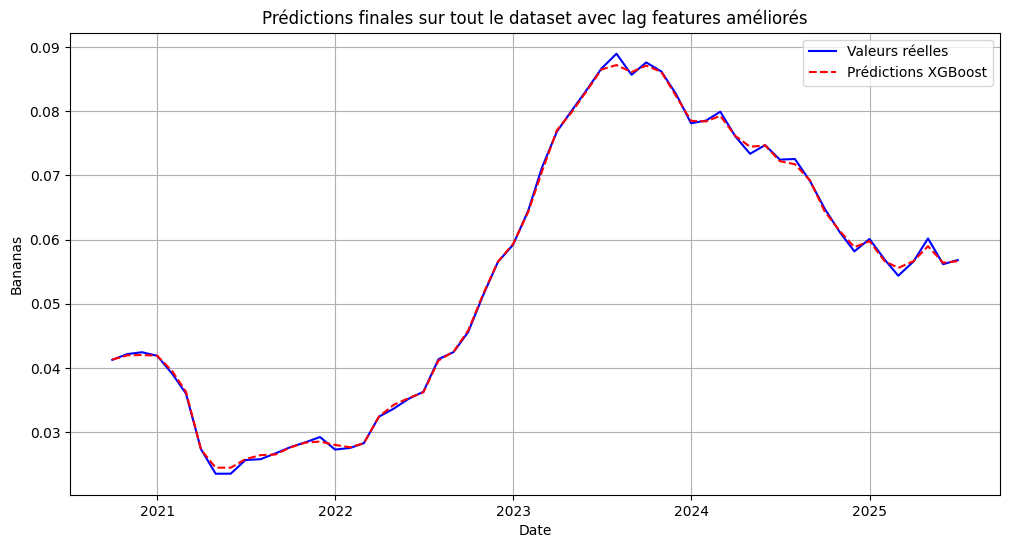

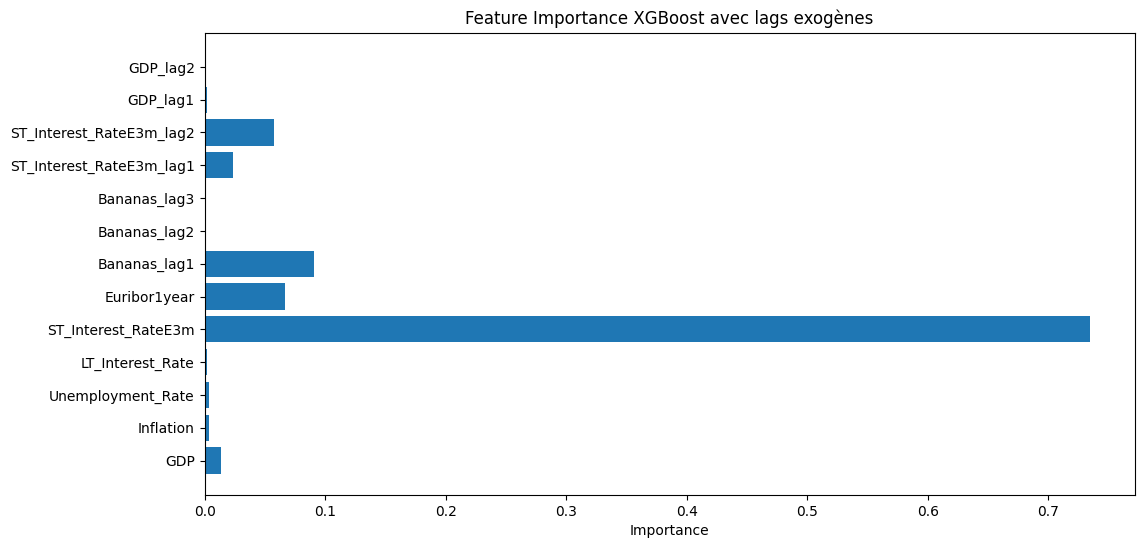

In [227]:
#meilleur modele xgboost avec lag et k fold 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns

# --- 1. Fonction pour créer les lags ---
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog={}):
    """
    df : dataframe
    target_col : colonne cible (Bananas)
    lags_target : lags sur la target
    lags_exog : dict {feature_name: [list_of_lags]}
    """
    df_lag = df.copy()
    
    # Lags sur la target
    for lag in lags_target:
        df_lag[f'{target_col}_lag{lag}'] = df_lag[target_col].shift(lag)
    
    # Lags sur les features exogènes
    for feature, lags in lags_exog.items():
        for lag in lags:
            df_lag[f'{feature}_lag{lag}'] = df_lag[feature].shift(lag)
    
    df_lag = df_lag.dropna()
    return df_lag

# Lags
lags_target = [1,2,3]
lags_exog = {
    'ST_Interest_RateE3m': [1,2],
    'GDP': [1,2]
}

df_lag = create_lag_features(df_known, 'Bananas', lags_target=lags_target, lags_exog=lags_exog)

# --- 2. Matrice de corrélation ---
plt.figure(figsize=(12,10))
sns.heatmap(df_lag.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

# --- 3. Définir features et target ---
features = ['GDP', 'Inflation', 'Unemployment_Rate', 
            'LT_Interest_Rate', 'ST_Interest_RateE3m', 'Euribor1year'] + \
           [f'Bananas_lag{lag}' for lag in lags_target] + \
           [f'{feat}_lag{lag}' for feat, lags in lags_exog.items() for lag in lags]

X_all = df_lag[features]
y_all = df_lag['Bananas']

# --- 4. K-Fold Cross-Validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_folds = []

plt.figure(figsize=(12,6))
for i, (train_index, val_index) in enumerate(kf.split(X_all)):
    X_tr, X_val = X_all.iloc[train_index], X_all.iloc[val_index]
    y_tr, y_val = y_all.iloc[train_index], y_all.iloc[val_index]
    
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_tr, y_tr)
    
    y_pred_fold = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_fold))
    rmse_folds.append(rmse)
    
    # Plot des prédictions vs réelles
    plt.scatter(val_index, y_val, label=f'Valeurs réelles fold {i+1}', marker='o')
    plt.scatter(val_index, y_pred_fold, label=f'Prédictions fold {i+1}', marker='x')
    
    print(f"Fold {i+1} RMSE: {rmse:.5f}")

plt.xlabel('Index')
plt.ylabel('Bananas')
plt.title('XGBoost avec lag features (K-Fold CV amélioré)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

print(f"RMSE moyen sur tous les folds: {np.mean(rmse_folds):.5f}")

# --- 5. Entraînement final sur tout le dataset ---
model_final = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
model_final.fit(X_all, y_all)

y_pred_all = model_final.predict(X_all)

plt.figure(figsize=(12,6))
plt.plot(df_lag.index, y_all.values, label='Valeurs réelles', color='blue')
plt.plot(df_lag.index, y_pred_all, label='Prédictions XGBoost', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Bananas')
plt.title('Prédictions finales sur tout le dataset avec lag features améliorés')
plt.legend()
plt.grid(True)
plt.show()

# --- 6. Feature importance ---
importances = model_final.feature_importances_
plt.figure(figsize=(12,6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importance XGBoost avec lags exogènes")
plt.show()


### Code to apply the model for our forecast of 2026

In [228]:
#meilleurs resultats en xgboost et réalisation 
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1. Concaténer historique et futur
df_full = pd.concat([df_known, df_forecast])
df_full = df_full.sort_index()

# 2. Créer les lags
def create_lag_features(df, target_col, lags_target=[1,2,3], lags_exog=[1]):
    df_lagged = df.copy()
    # Lags de la variable cible
    for lag in lags_target:
        df_lagged[f"{target_col}_lag{lag}"] = df_lagged[target_col].shift(lag)
    # Lags pour les variables exogènes
    for col in df.columns:
        if col != target_col:
            for lag in lags_exog:
                df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    return df_lagged

lags_target = [1,2,3]
lags_exog = [1]

df_full_lag = create_lag_features(df_full, "Bananas", lags_target, lags_exog)

# 3. Séparer historique et futur
df_train_lag = df_full_lag.loc[df_full_lag.index].dropna()

X_train = df_train_lag.drop(columns=["Bananas"])
y_train = df_train_lag["Bananas"]

# Entraînement du modèle
model = RandomForestRegressor(random_state=0, n_estimators=500)
model.fit(X_train, y_train)

# Erreur sur l’historique
y_train_pred = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE (train):", rmse_train)

# 4. Prédictions itératives sur le futur
df_future_preds = df_full_lag.loc[df_forecast.index].copy()
features = X_train.columns  # mêmes features qu’au training
y_pred_future = []

for date in df_future_preds.index:
    # Features du mois t
    X_t = df_future_preds.loc[date, features].values.reshape(1, -1)
    # Prédiction Bananas_t
    y_t = model.predict(X_t)[0]
    df_future_preds.loc[date, "Bananas_pred"] = y_t
    y_pred_future.append(y_t)
    
    # Mise à jour des lags pour le mois suivant
    next_idx = df_future_preds.index.get_loc(date) + 1
    if next_idx < len(df_future_preds):
        next_date = df_future_preds.index[next_idx]
        df_future_preds.loc[next_date, "Bananas_lag1"] = y_t
        df_future_preds.loc[next_date, "Bananas_lag2"] = df_future_preds.loc[date, "Bananas_lag1"]
        df_future_preds.loc[next_date, "Bananas_lag3"] = df_future_preds.loc[date, "Bananas_lag2"]

# Résultat final
print("\nPrévisions Bananas 2025-08 → 2026-12 :")
print(df_future_preds[["Bananas_pred"]])
df_future_preds

RMSE (train): 0.0009305790667829248


/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/eloikling1/ml_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegress


Prévisions Bananas 2025-08 → 2026-12 :
            Bananas_pred
DATE                    
2025-08-01      0.058780
2025-09-01      0.058837
2025-10-01      0.057981
2025-11-01      0.057876
2025-12-01      0.057862
2026-01-01      0.057527
2026-02-01      0.056772
2026-03-01      0.056751
2026-04-01      0.056748
2026-05-01      0.056708
2026-06-01      0.056737
2026-07-01      0.056750
2026-08-01      0.056509
2026-09-01      0.055744
2026-10-01      0.055689
2026-11-01      0.055492
2026-12-01      0.055493


,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_RateE3m,Euribor1year,Bananas_lag1,Bananas_lag2,Bananas_lag3,GDP_lag1,Inflation_lag1,Unemployment_Rate_lag1,LT_Interest_Rate_lag1,ST_Interest_RateE3m_lag1,Euribor1year_lag1,Bananas_pred
DATE,,,,,,,,,,,,,,,,,
2025-08-01,NaN,1.85,2.5,6.256436,2.847713,2.673615,1.908,0.056817,0.056180,0.060178,0.60,2.5,5.900000,3.110000,1.990000,2.080,0.058780
2025-09-01,NaN,1.85,2.5,6.256436,2.847713,2.673615,1.867,0.058780,0.056817,0.056180,1.85,2.5,6.256436,2.847713,2.673615,1.908,0.058837
2025-10-01,NaN,1.78,2.5,6.209587,2.797713,2.423615,1.844,0.058837,0.058780,0.056817,1.85,2.5,6.256436,2.847713,2.673615,1.867,0.057981
2025-11-01,NaN,1.78,2.5,6.209587,2.797713,2.423615,1.875,0.057981,0.058837,0.058780,1.78,2.5,6.209587,2.797713,2.423615,1.844,0.057876
2025-12-01,NaN,1.78,2.5,6.209587,2.797713,2.423615,1.763,0.057876,0.057981,0.058837,1.78,2.5,6.209587,2.797713,2.423615,1.875,0.057862
2026-01-01,NaN,1.79,2.5,6.400000,1.708000,2.423615,2.097,0.057862,0.057876,0.057981,1.78,2.5,6.209587,2.797713,2.423615,1.763,0.057527
2026-02-01,NaN,1.79,2.5,6.400000,1.637000,2.423615,1.971,0.057527,0.057862,0.057876,1.79,2.5,6.400000,1.708000,2.423615,2.097,0.056772
2026-03-01,NaN,1.79,2.5,6.400000,1.624000,2.423615,1.899,0.056772,0.057527,0.057862,1.79,2.5,6.400000,1.637000,2.423615,1.971,0.056751
2026-04-01,NaN,1.87,2.5,6.400000,1.639000,2.423615,1.805,0.056751,0.056772,0.057527,1.79,2.5,6.400000,1.624000,2.423615,1.899,0.056748


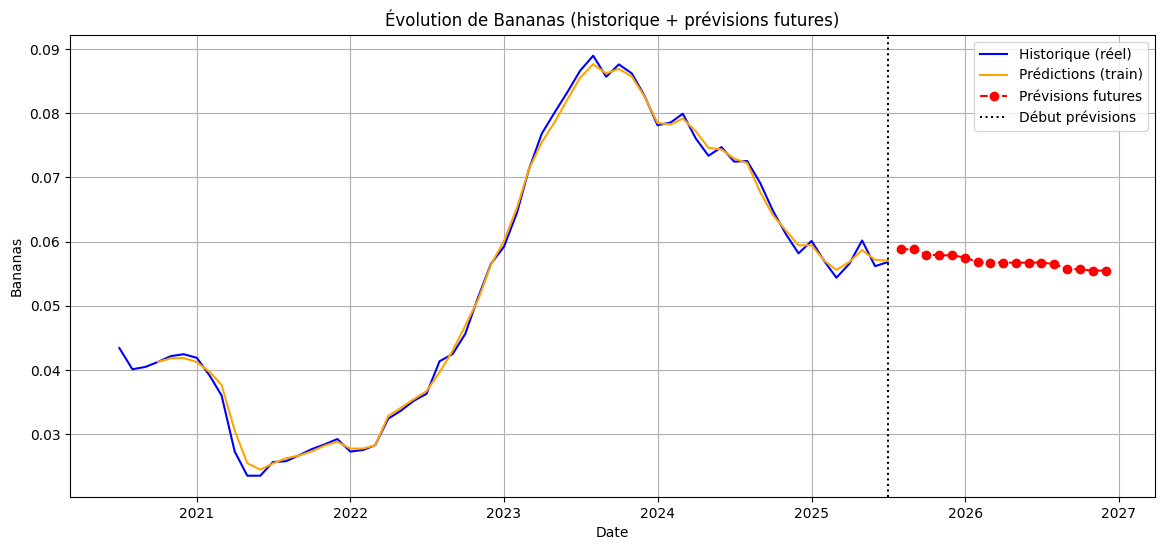

In [229]:
#plot des resultats pr 2026
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Historique réel
plt.plot(df_known.index, df_known["Bananas"], label="Historique (réel)", color="blue")

# Prédictions sur la période d'entraînement
#plt.plot(df_known.index, y_train_pred, label="Prédictions (train)", color="orange")
plt.plot(y_train.index, y_train_pred, label="Prédictions (train)", color="orange")

# Prévisions futures
plt.plot(df_future_preds.index, df_future_preds["Bananas_pred"], 
         label="Prévisions futures", color="red", linestyle="--", marker="o")

# Ligne verticale au moment de la coupure
plt.axvline(x=df_known.index[-1], color="black", linestyle=":", label="Début prévisions")

plt.title("Évolution de Bananas (historique + prévisions futures)")
plt.xlabel("Date")
plt.ylabel("Bananas")
plt.legend()
plt.grid(True)
plt.show()


---

---

## Annexe

RMSE forecast itératif sur test: 0.00723


/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_1773/1728000607.py:46: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_copy[f'Bananas_lag{lag}'].iloc[i + lag] = y_hat
/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_1

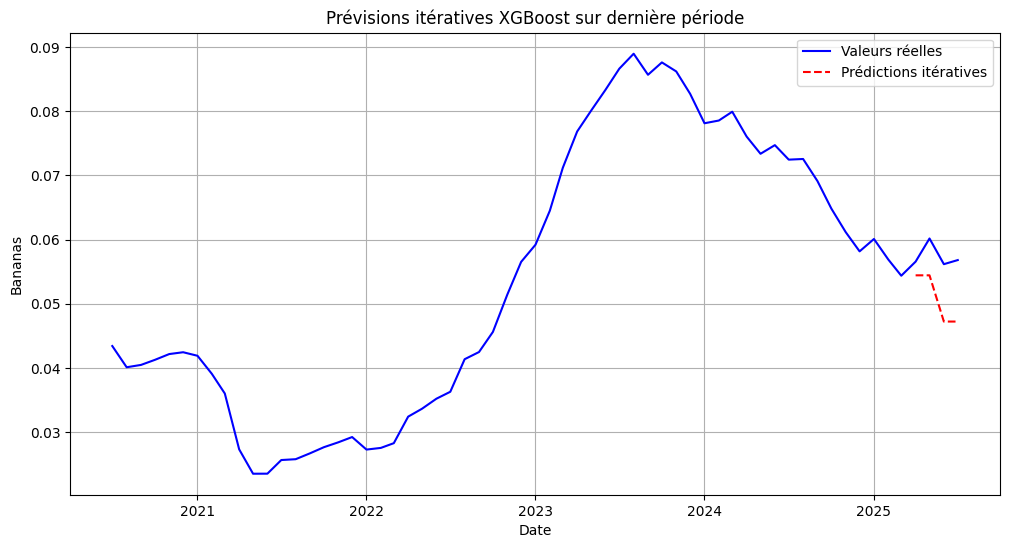

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


# --- Créer les lags sur la target ---
def create_lag_features(df, target_col, lags=[1,2,3]):
    df_lag = df.copy()
    for lag in lags:
        df_lag[f'{target_col}_lag{lag}'] = df_lag[target_col].shift(lag)
    return df_lag

lags = [1,2,3]
df_lag = create_lag_features(df_known, 'Bananas', lags)

# --- Split train/test ---
train = df_lag.loc[:'2025-03'].dropna()  # adapter date si nécessaire
test = df_lag.loc['2025-04':].copy()     # dernière période à prédire

features = ['GDP', 'Inflation', 'Unemployment_Rate', 
            'LT_Interest_Rate', 'ST_Interest_RateE3m', 'Euribor1year'] + [f'Bananas_lag{lag}' for lag in lags]

X_train = train[features]
y_train = train['Bananas']

# --- Entraînement modèle ---
model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# --- Forecast itératif sur test ---
y_pred_test = []
test_copy = test.copy()

for i in range(len(test)):
    X_test_row = test_copy[features].iloc[i:i+1].copy()
    
    # Prédire
    y_hat = model.predict(X_test_row)[0]
    y_pred_test.append(y_hat)
    
    # Mettre à jour les lags pour la prochaine ligne
    for lag in lags:
        if i + lag < len(test_copy):
            test_copy[f'Bananas_lag{lag}'].iloc[i + lag] = y_hat

# --- RMSE sur test ---
rmse_test = np.sqrt(mean_squared_error(test['Bananas'], y_pred_test))
print(f"RMSE forecast itératif sur test: {rmse_test:.5f}")

# --- Plot final ---
plt.figure(figsize=(12,6))
plt.plot(df_known.index, df_known['Bananas'], label='Valeurs réelles', color='blue')
plt.plot(test.index, y_pred_test, label='Prédictions itératives', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Bananas')
plt.title('Prévisions itératives XGBoost sur dernière période')
plt.legend()
plt.grid(True)
plt.show()


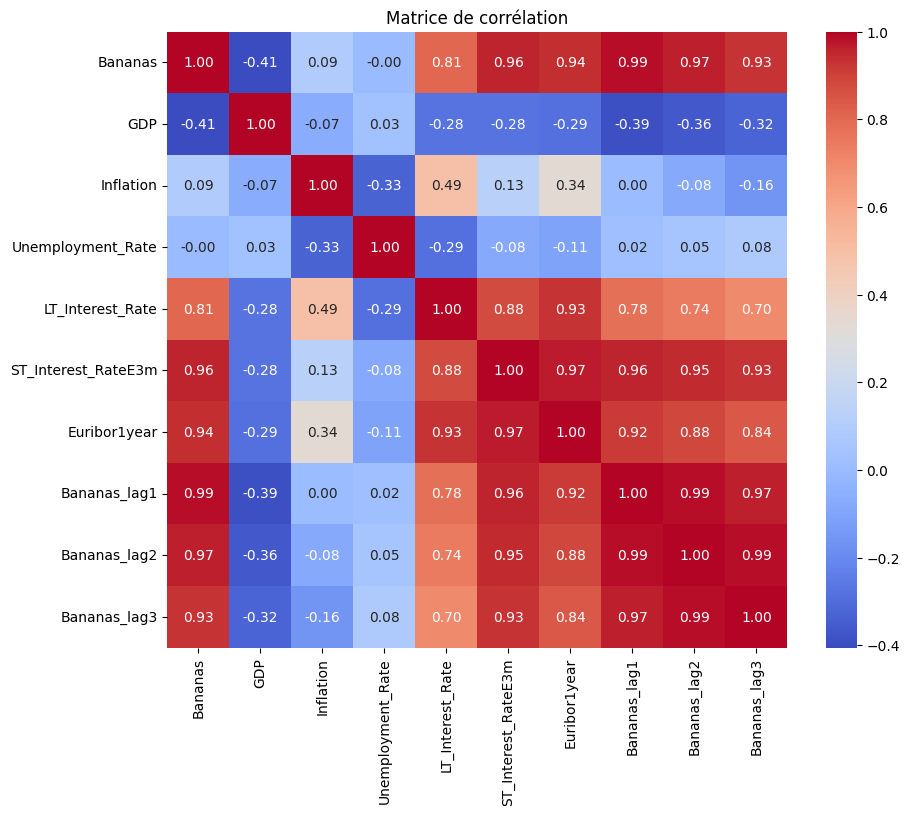

/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_1773/842580840.py:59: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  val_copy[f'Bananas_lag{lag}'].iloc[j + lag] = y_hat
/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_177

Fold 1 RMSE itératif: 0.00619
Fold 2 RMSE itératif: 0.00645
Fold 3 RMSE itératif: 0.00583


/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_1773/842580840.py:59: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  val_copy[f'Bananas_lag{lag}'].iloc[j + lag] = y_hat
/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_177

Fold 4 RMSE itératif: 0.00800
Fold 5 RMSE itératif: 0.00526


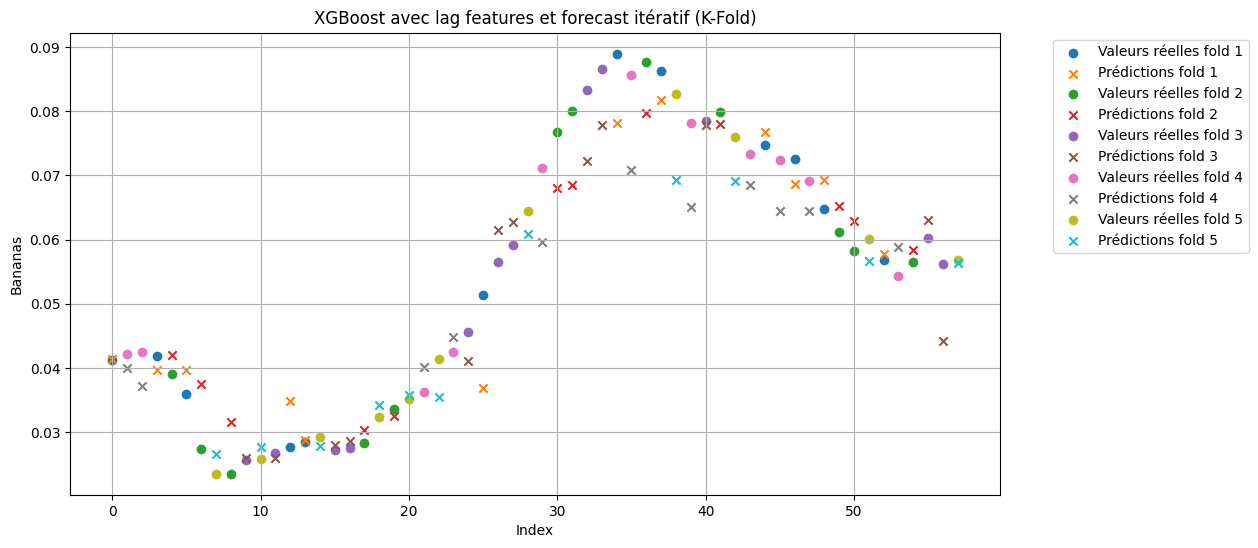

RMSE moyen sur tous les folds: 0.00635


/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_1773/842580840.py:96: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test_copy[f'Bananas_lag{lag}'].iloc[i + lag] = y_hat
/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_17

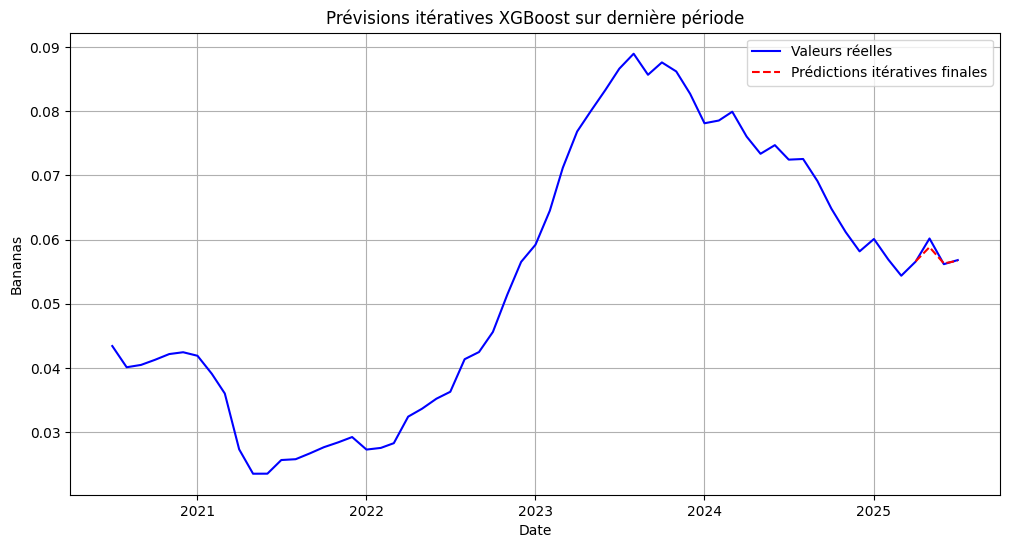

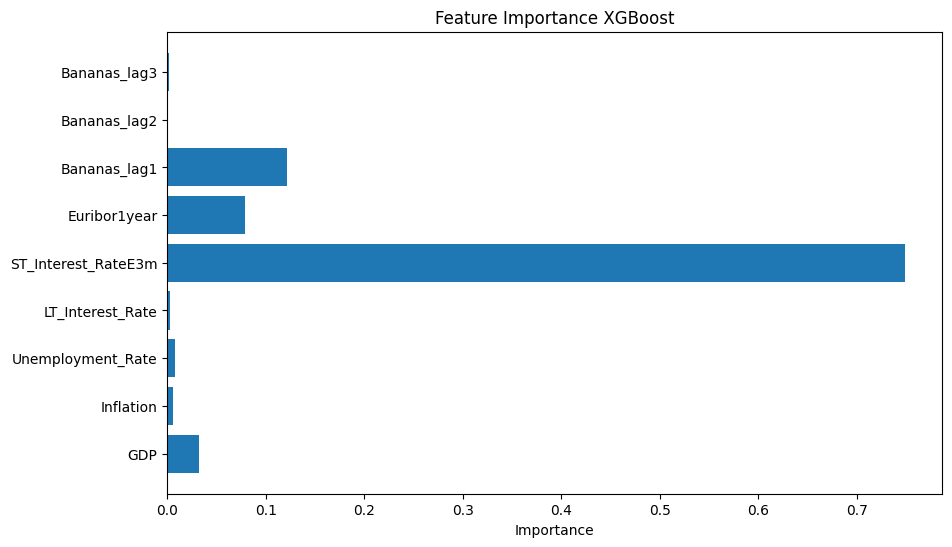

In [231]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns



# --- Créer les lags sur la target ---
def create_lag_features(df, target_col, lags=[1,2,3]):
    df_lag = df.copy()
    for lag in lags:
        df_lag[f'{target_col}_lag{lag}'] = df_lag[target_col].shift(lag)
    df_lag = df_lag.dropna()
    return df_lag

lags = [1,2,3]
df_lag = create_lag_features(df_known, 'Bananas', lags)

# --- Matrice de corrélation ---
plt.figure(figsize=(10,8))
sns.heatmap(df_lag.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

# --- Features et target ---
features = ['GDP', 'Inflation', 'Unemployment_Rate', 
            'LT_Interest_Rate', 'ST_Interest_RateE3m', 'Euribor1year'] + [f'Bananas_lag{lag}' for lag in lags]

X_all = df_lag[features]
y_all = df_lag['Bananas']

# --- K-Fold CV avec forecast itératif ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_folds = []

plt.figure(figsize=(12,6))
for i, (train_index, val_index) in enumerate(kf.split(X_all)):
    X_tr, X_val = X_all.iloc[train_index].copy(), X_all.iloc[val_index].copy()
    y_tr, y_val = y_all.iloc[train_index], y_all.iloc[val_index]
    
    model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_tr, y_tr)
    
    # Forecast itératif sur fold de validation
    y_pred_fold = []
    val_copy = X_val.copy()
    
    for j in range(len(val_copy)):
        X_val_row = val_copy.iloc[j:j+1].copy()
        y_hat = model.predict(X_val_row)[0]
        y_pred_fold.append(y_hat)
        
        # Mise à jour des lags
        for lag in lags:
            if j + lag < len(val_copy):
                val_copy[f'Bananas_lag{lag}'].iloc[j + lag] = y_hat
    
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_fold))
    rmse_folds.append(rmse)
    
    # Plot prédictions vs réelles
    plt.scatter(val_index, y_val, label=f'Valeurs réelles fold {i+1}', marker='o')
    plt.scatter(val_index, y_pred_fold, label=f'Prédictions fold {i+1}', marker='x')
    
    print(f"Fold {i+1} RMSE itératif: {rmse:.5f}")

plt.xlabel('Index')
plt.ylabel('Bananas')
plt.title('XGBoost avec lag features et forecast itératif (K-Fold)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

print(f"RMSE moyen sur tous les folds: {np.mean(rmse_folds):.5f}")

# --- Entraînement final sur tout le dataset ---
model_final = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
model_final.fit(X_all, y_all)

# --- Forecast itératif sur toute la période future (ex: test set) ---
test = df_lag.loc['2025-04':].copy()  # adapter la période finale
y_pred_test = []

test_copy = test.copy()
for i in range(len(test)):
    X_test_row = test_copy[features].iloc[i:i+1].copy()
    y_hat = model_final.predict(X_test_row)[0]
    y_pred_test.append(y_hat)
    
    # Mise à jour des lags
    for lag in lags:
        if i + lag < len(test_copy):
            test_copy[f'Bananas_lag{lag}'].iloc[i + lag] = y_hat

# --- Plot final ---
plt.figure(figsize=(12,6))
plt.plot(df_known.index, df_known['Bananas'], label='Valeurs réelles', color='blue')
plt.plot(test.index, y_pred_test, label='Prédictions itératives finales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Bananas')
plt.title('Prévisions itératives XGBoost sur dernière période')
plt.legend()
plt.grid(True)
plt.show()

# --- Feature importance finale ---
importances = model_final.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importance XGBoost")
plt.show()


---

---

In [232]:
# Supposons que future_df contient tes colonnes exogènes de 2025-08 à 2026-12
future_df = df_forecast.copy()  # pour être sûr de ne pas modifier l'original
lags = [1, 2, 3]
target = 'Bananas'

# Initialiser les colonnes de lags
for lag in lags:
    future_df[f'{target}_lag{lag}'] = np.nan

# Remplir les premiers lags avec les dernières valeurs réelles
for i, lag in enumerate(lags):
    future_df[f'{target}_lag{lag}'].iloc[0:i+1] = df_lag[target].iloc[-(i+1):].values[::-1]

# Itération pour prédire Bananas
preds = []
features = ['GDP', 'Inflation', 'Unemployment_Rate', 
            'LT_Interest_Rate', 'ST_Interest_RateE3m', 'Euribor1year'] + [f'{target}_lag{lag}' for lag in lags]

for i in range(len(future_df)):
    X_row = future_df.iloc[i:i+1][features]
    y_hat = model.predict(X_row)[0]
    preds.append(y_hat)
    
    # Mettre à jour les lags pour les lignes suivantes
    for lag in lags:
        if i + lag < len(future_df):
            future_df[f'{target}_lag{lag}'].iloc[i + lag] = y_hat

future_df['Bananas_pred'] = preds
future_df


/var/folders/yb/rh2b9l9n369fmm3cb0qrfhn40000gp/T/ipykernel_1773/1313639804.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  future_df[f'{target}_lag{lag}'].iloc[0:i+1] = df_lag[target].iloc[-(i+1):].values[::-1]
/var/folders/yb/rh2b9l9n3

,Bananas,GDP,Inflation,Unemployment_Rate,LT_Interest_Rate,ST_Interest_RateE3m,Euribor1year,Bananas_lag1,Bananas_lag2,Bananas_lag3,Bananas_pred
DATE,,,,,,,,,,,
2025-08-01,NaN,1.85,2.5,6.256436,2.847713,2.673615,1.908,0.056817,0.056817,0.056817,0.058248
2025-09-01,NaN,1.85,2.5,6.256436,2.847713,2.673615,1.867,0.058248,0.056180,0.056180,0.058248
2025-10-01,NaN,1.78,2.5,6.209587,2.797713,2.423615,1.844,0.058248,0.058248,0.060178,0.058083
2025-11-01,NaN,1.78,2.5,6.209587,2.797713,2.423615,1.875,0.058083,0.058248,0.058248,0.058083
2025-12-01,NaN,1.78,2.5,6.209587,2.797713,2.423615,1.763,0.058083,0.058083,0.058248,0.058083
2026-01-01,NaN,1.79,2.5,6.400000,1.708000,2.423615,2.097,0.058083,0.058083,0.058083,0.057116
2026-02-01,NaN,1.79,2.5,6.400000,1.637000,2.423615,1.971,0.057116,0.058083,0.058083,0.057116
2026-03-01,NaN,1.79,2.5,6.400000,1.624000,2.423615,1.899,0.057116,0.057116,0.058083,0.057116
2026-04-01,NaN,1.87,2.5,6.400000,1.639000,2.423615,1.805,0.057116,0.057116,0.057116,0.057116
